In [ ]:
!pip install kaggle

In [1]:
# the imports
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from sklearn import feature_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

In [ ]:
# upload kaggle.json (kaggle creds file) for the kaggle api
files.upload()

In [3]:
# make, copy, set permissions, download, unzip
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle competitions download -c house-prices-advanced-regression-techniques
!unzip house-prices-advanced-regression-techniques.zip

-rw-r--r-- 1 root root 72 Jul 28 15:00 kaggle.json
/content
  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 110MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [74]:
# to pandas
data_desc = pd.read_fwf('data_description.txt')
data_samp_sub = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [55]:
def categorical_scaling(ordered_category_list, data):
  tmp = list(range(1,len(ordered_category_list)))
  t = {data[i]: tmp[i] for i in range(len(tmp))}
  data = data.map(t)
  return data

In [72]:
def clean_data(data):
  """
  Sifting, sorting, feature engineering, the good stuff....
  This time I am going to try and look for features akin to what is listed on realtor sites and items from investopedia (age, rooms, bathrooms, sq. ft, location, etc.)
  I will drop features as much as possible.
  :param data: The pandas DataFrame being manipulated for this specific problem
  """
  '''
  has pool done
  age done
  has basement done
  total rooms done
  bathrooms done
  bedrooms done
  total home sq ft done
  neighborhood (order by median in train to reassign for train and test) done
  has fireplace done
  acreage done
  condition (although it may be subjective in this dataset) done
  single family bool done
  heating type bool done
  '''

  # dropping Year Built as year remodeled contains latest year worked on or year built (almost the same data and correlation)
  # leaving remodeled at scale as newer (larger number) seems to translate to higher value
  data.drop('YearBuilt', axis=1, inplace=True)
  # dropping poolqc as no obvious (strong) correlation
  data.drop('PoolQC', axis=1,inplace=True)
  # turning pool area into a has pool bool
  data['PoolArea'] = np.where(data['PoolArea'] > 0,1,0)
  # dropping Street
  data.drop('Street', axis=1,inplace=True)
  # dropping MSZoning this time
  data.drop('MSZoning', axis=1,inplace=True)
  # I believe paved allys would likely be in less rural areas. Cities can have paved allys in poor or better neighboorhoods. Using one hot might weigh model toward paved when places have none as well.
  data.drop('Alley', axis=1, inplace=True)
  # LandContour and LotShape have similar BoxPlots and may be correlated. Dropping LotShape. Dropping LandContour as homes already exist on the land.
  data.drop('LandContour', axis=1, inplace=True)
  data.drop('LotShape', axis=1, inplace=True)
  # drop both LotConfig and LandSlope
  data.drop('LotConfig', axis=1, inplace=True)
  data.drop('LandSlope', axis=1, inplace=True)
  # dropping feature desciption and keeping value, value should be indicative without the item class for regression. Also, The shed has a wide range of added value.
  data.drop('MiscFeature', axis=1, inplace=True)
  # switching BldgType to two categories, single family or not
  data['BldgCatSingle'] = np.where(data['BldgType'] == '1Fam',1,0)
  # drop bldgType now that BldgCatSingle available
  data.drop('BldgType', axis=1, inplace=True)
  # drop HouseStyle and MSSubClass
  data.drop('HouseStyle', axis=1, inplace=True)
  data.drop('MSSubClass', axis=1, inplace=True)
  # keeping lot area this time for acreage calc
  # dropping Utilities as this seems primarily be sampling of city with municiplal, no as unique
  data.drop('Utilities', axis=1, inplace=True)
  # Neighborhood moved out of the this function for train only calcs to apply to test
  # dropping second condition and drop first condition
  data.drop('Condition2', axis=1, inplace=True)
  data.drop('Condition1', axis=1, inplace=True)
  # OverallQual kept the same
  # OverallCond dropped (not as ordered)
  data.drop('OverallCond', axis=1, inplace=True)
  # RoofMatl drop
  data.drop('RoofMatl', axis=1, inplace=True)
  # Roof style does not seem as correlative dropping
  data.drop('RoofStyle', axis=1, inplace=True)
  # siding might be wrong, both 1st and 2nd list shingles (roofing) as a type of common siding. Dropping them.
  data.drop(['Exterior1st','Exterior2nd'], axis=1, inplace=True)
  # not correlating to sale price visually
  data.drop('MasVnrArea', axis=1, inplace=True)
  # not on the list dropping
  data.drop('MasVnrType', axis=1, inplace=True)
  # Rescale to numeric ExterCond without dummies (want one column with 1-5 with 5 being best)
  data['ExterCond'] = categorical_scaling(['PO', 'FA', 'TA', 'GD', 'EX'], data['ExterCond'])
  data['ExterCond'] = np.nan_to_num(data['ExterCond'])
  # Drop ExterQual
  data.drop('ExterQual', axis=1, inplace=True)
  # foundation seems non-correlative
  data.drop('Foundation', axis=1, inplace=True)
  # replacing with bool for has basement
  data['BsmtCond'] = np.where(data['BsmtCond'] != np.nan, 1, 0)
  # drop features that don't look correlative
  data.drop(['BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1',
                    'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'], axis=1, inplace=True)
  # drop feature that does not seem correlative
  data.drop(['SaleType','SaleCondition'], axis=1, inplace=True)
  # drop feature that does not seem correlative (this data set does have noticable mean differences for year/month)
  data.drop(['MoSold','YrSold'], axis=1, inplace=True)
  # drop
  data.drop('Fence', axis=1, inplace=True)
  # type with gas in name correlated to much higher prices
  data['Heating'] = np.where(data['Heating'].str.contains('Gas', regex=True),1,0)
  # drop (ohio data)
  data.drop('CentralAir', axis=1, inplace=True)
  # subjective and not highly correlative
  data.drop('HeatingQC', axis=1, inplace=True)
  # dropping
  data.drop('Electrical', axis=1, inplace=True)
  # drop
  data.drop('LowQualFinSF', axis=1, inplace=True)
  # utilize count of baths and drop bath features
  data['BathCount'] = (data['BsmtFullBath'] + data['FullBath']) + (data['BsmtHalfBath'] + data['HalfBath'] *.5)
  # ensure no nans
  data['BathCount'] = np.nan_to_num(data['BathCount'])
  data.drop(['BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath'], axis=1, inplace=True)
  # getting counts
  data['TotalRooms'] = data['BedroomAbvGr'] + data['KitchenAbvGr'] + data['BathCount']
  data.drop('KitchenAbvGr', axis=1, inplace=True)
  # drop KitchenQual
  data.drop('KitchenQual', axis=1, inplace=True)
  # drop as not obviously correlative
  data.drop('Functional', axis=1, inplace=True)
  # switch count to bool
  data['Fireplaces'] = np.where(data['Fireplaces'] > 0,1,0)
  # drop
  data.drop('FireplaceQu', axis=1, inplace=True)
  # various garage items not highly correlative
  data.drop(['GarageType','GarageYrBlt','GarageFinish','GarageArea','GarageQual','GarageCond'],axis=1,inplace=True)
  # drop
  data.drop('PavedDrive', axis=1, inplace=True)
  # drop various features deemed uncorrelative or unimportant
  data.drop('WoodDeckSF',axis=1,inplace=True)
  data.drop('OpenPorchSF',axis=1,inplace=True)
  data.drop('EnclosedPorch',axis=1,inplace=True)
  data.drop('3SsnPorch',axis=1,inplace=True)
  data.drop('ScreenPorch',axis=1,inplace=True)
  data.drop('LotFrontage',axis=1,inplace=True)
  return data

In [75]:
# update test and train with the feature engineering changes
train = clean_data(train)
test = clean_data(test)
train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)

In [76]:
# neighborhoods median price
l = train['SalePrice'].groupby(train['Neighborhood']).mean().to_dict()
train['Neighborhood'] = train['Neighborhood'].map(l)
test['Neighborhood'] = test['Neighborhood'].map(l)

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   LotArea        1460 non-null   int64  
 2   Neighborhood   1460 non-null   float64
 3   OverallQual    1460 non-null   int64  
 4   YearRemodAdd   1460 non-null   int64  
 5   ExterCond      1460 non-null   float64
 6   BsmtCond       1460 non-null   int64  
 7   Heating        1460 non-null   int64  
 8   1stFlrSF       1460 non-null   int64  
 9   2ndFlrSF       1460 non-null   int64  
 10  GrLivArea      1460 non-null   int64  
 11  BedroomAbvGr   1460 non-null   int64  
 12  TotRmsAbvGrd   1460 non-null   int64  
 13  Fireplaces     1460 non-null   int64  
 14  GarageCars     1460 non-null   int64  
 15  PoolArea       1460 non-null   int64  
 16  MiscVal        1460 non-null   int64  
 17  SalePrice      1460 non-null   int64  
 18  BldgCatS

In [78]:
# split, scale, set early stopping
labels = train['SalePrice']
features = train.drop('SalePrice',axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
early_stop = EarlyStopping(monitor='val_loss',verbose=1,patience=25)

In [79]:
# sequential ann model set for linear with mse loss
model = Sequential()
model.add(Dense(100,activation='relu'))
#model.add(Dropout(rate=.7))
model.add(Dense(75,activation='relu'))
#model.add(Dropout(rate=.6))
model.add(Dense(50,activation='relu'))
#model.add(Dropout(rate=.5))
model.add(Dense(25,activation='relu'))
#model.add(Dropout(rate=.4))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='adam')

In [ ]:
# fit the model to the test data
hist = model.fit(x=X_train,y=y_train,epochs=500, validation_data=(X_test,y_test),callbacks=[early_stop])

In [81]:
# mount and save model if wanted, I utilized Colab notebooks for this
model.save('./drive/MyDrive/Colab_Notebooks/adv_reg_model_10.keras')

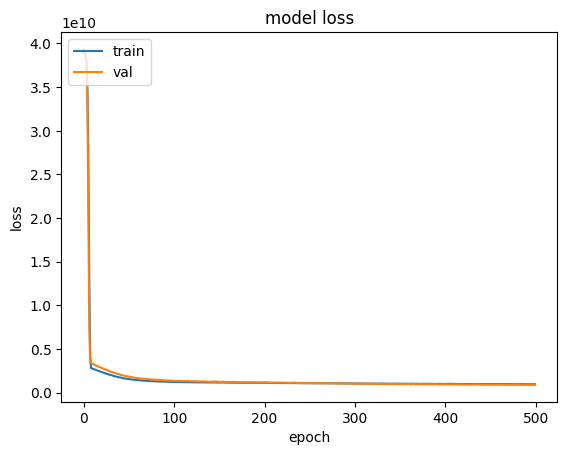

In [82]:
# Plot the loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [83]:
# checking X_test output
z = model.predict(X_test)
print(z[0])

14/14 [==============================] - 0s 1ms/step
[143991.17]


In [84]:
# scale the test
test = scaler.transform(test)

In [85]:
b = model.predict(test)

46/46 [==============================] - 0s 967us/step


In [86]:
data_samp_sub['SalePrice'] = b

In [87]:
temp_samp = pd.read_csv('sample_submission.csv')
temp_samp

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [91]:
data_samp_sub.iloc[1118]

Id            2579.000000
SalePrice    60869.289062
Name: 1118, dtype: float64

In [89]:
data_samp_sub.to_csv('submission.csv',index=False)

In [90]:
# My second submission!!!!!
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Second ann try"

100% 21.2k/21.2k [00:02<00:00, 10.3kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques